In [1]:
import xarray as xr
import pandas as pd
import polars as pl
import numpy as np
from fastapi import FastAPI, HTTPException, Query, Response
from fastapi.responses import JSONResponse, FileResponse
from fastapi.openapi.docs import get_swagger_ui_html
from fastapi.openapi.utils import get_openapi
from typing import Optional, List
from pydantic import BaseModel
from datetime import date, datetime, timedelta
from tempfile import NamedTemporaryFile
import json, dask
# This is a more low-level way of setting up Dask for parallel computations, and it doesn't provide some of the additional features of Dask's own distributed scheduler, such as advanced task prioritization and data locality awareness.
#from multiprocessing.pool import Pool 
#dask.config.set(pool=Pool(4))
#from dask.distributed import Client, LocalCluster
#client = Client(n_workers=4) #fixed cores
#cluster = LocalCluster() #dynamic assign
#client = Client(cluster)
from dask.distributed import Client
client = Client('tcp://localhost:8786')

import time

In [13]:
#print(client)

<Client: 'tcp://127.0.0.1:46113' processes=4 threads=8, memory=62.66 GiB>


In [2]:
st = time.time()
dz = xr.open_zarr(
    #'sst_anomaly.zarr', chunks='auto', 
    '../data/mhw.zarr', chunks='auto', 
    group='anomaly', decode_times=True)

et = time.time()
print('Exe time: ', et-st, 'sec')
dz
gridSz = 0.25
timeLimit = 365
LON_RANGE_LIMIT = 90
LAT_RANGE_LIMIT = 90

Exe time:  0.22722363471984863 sec


In [3]:
def deg2str(value, isLon=True, oriNeg=False, roundTo=3):
    if (isLon):
      # if original lon is -180 -> 180 + 360 = 180 -> deg2str -> 180 cannot convert back to -180
      lon = value - 360 if value > 180 or oriNeg else value
      return str(round(lon, roundTo)).replace(".", "d")

    return str(round(value, roundTo)).replace(".", "d")

def to_nearest_grid_point(lon: float, lat: float) -> tuple:
    mlon = 180 if lon > 180 else (-180 if lon < -180 else lon)
    mlat = 90 if lat > 90 else (-90 if lat < -90 else lat)
    grid_lon = round(mlon * 4) / 4
    grid_lat = round(mlat * 4) / 4
    grid_lon = grid_lon + 360 if grid_lon < 0 else grid_lon
    return (grid_lon, grid_lat)

In [18]:
#def process_data_subset(data_subset): ## , **kwargs
#    area_mean = data_subset.mean(dim=['lon', 'lat'], skipna=True).dropna(dim='date', how='all') #.compute()
#  ##Not solved: "TypeError: object DataFrame can't be used in 'await' expression".
#    df = area_mean[['date', kwargs['append']]].to_dataframe().reset_index()
#    return client.compute(area_mean)

In [4]:
from fastapi import FastAPI
import asyncio
app = FastAPI()

In [5]:
def output_df(df, isoTime=False):
    if df.empty:
        raise HTTPException(
            status_code=400, detail="No data available after removing rows with NA values.")

    st = time.time()
    pl_df = pl.from_pandas(df) 
    if (isoTime):
        pl_df = pl_df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))
    # if 'date' in df.columns: #### its slow!
    # df['date'] = df['date'].apply(
    # lambda x: x.isoformat() if not pd.isnull(x) else '')
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
    # df.fillna("", inplace=True)  # Replace NaN values with None #not "null"
    # return df #Pandas version
    et = time.time()
    print('Process date data time: ', et-st, 'sec')      

    return pl_df

In [6]:
#@app.get("/api/mhw")
#async
def process_mhw_data(lon0: float, lat0: float, lon1: Optional[float], lat1: Optional[float], start: Optional[date], end: Optional[date], append: Optional[str], mode: Optional[str] = None):
    if mode is None:
        mode = 'raw'

    if append is None:
        append = 'level'

    append = 'sst' if mode == 'area_mean_sst' else ('sst_anomaly' if mode == 'area_mean_sst_anomaly' else append)

    variables = list(set([var.strip() for var in append.split(',') if var.strip() in ['level', 'sst_anomaly', 'td', 'sst']]))
    if not variables:
        raise HTTPException(
            status_code=400, detail="Invalid variable(s). Allowed variables are 'sst_anomaly', 'level', and 'td'.")

    variables.sort() #in-place sort not return anything
    out_file = '-'.join(variables)

    if start is None:
        start_date = pd.to_datetime('1982-01-01')
    else:
        try:
            start_date = pd.to_datetime(start)
            start_date = start_date.replace(day=1)  # set day to 1
        except ValueError:
            raise HTTPException(
                status_code=400, detail="Invalid start date format")

    if end is None:
        end_date = pd.to_datetime(datetime.today())
    else:
        try:
            end_date = pd.to_datetime(end)
            end_date = end_date.replace(day=1)  # set day to 1
        except ValueError:
            raise HTTPException(
                status_code=400, detail="Invalid end date format")

    try:
        #print("current state: ", lon0, lat0, lon1, lat1, start_date, end_date, variables, mode)
        st = time.time()
        orig_lon0, orig_lon1 = lon0, lon1
        lon0, lat0 = to_nearest_grid_point(lon0, lat0)

        if lon1 is None or lat1 is None:
            # Only one point, no date range limitation
            out_file = (out_file + '_' + deg2str(lon0, True, orig_lon0<=-179.875) + '_' + deg2str(lat0, False) +
                        '_' + 'Point' + '_' + str(start_date.date()) + '_' + str(end_date.date()))
            data_subset = dz.sel(lon=slice(lon0, lon0+gridSz-0.01), lat=slice(
                lat0, lat0+gridSz-0.01), date=slice(start_date, end_date))

        else:
            # Bounding box, 1 month or 1 year date range limitation
            lon1, lat1 = to_nearest_grid_point(lon1, lat1)

            if (mode != 'area_mean_sst' and mode != 'area_mean_sst_anomaly' and mode != 'month_mean'):
                # Adjust temporal range limit based on spatial range
                lon_range = abs(orig_lon1 - orig_lon0)
                lat_range = abs(lat1 - lat0)
                area_range = lon_range * lat_range
                if (lon_range > LON_RANGE_LIMIT and lat_range > LAT_RANGE_LIMIT) or (area_range > AREA_LIMIT):
                    # Large spatial range, limit to one month of data
                    end_date = start_date + pd.DateOffset(months=1) - timedelta(days=1)
                elif (end_date - start_date).days > timeLimit:
                    # Smaller spatial range, limit to one year of data
                    end_date = start_date + timedelta(days=timeLimit)

            if lon0 > lon1 and np.sign(orig_lon0) == np.sign(orig_lon1):
                # Swap if lon0 > lon1 but the same sign
                lon0, lon1 = lon1, lon0
                orig_lon0, orig_lon1 = orig_lon1, orig_lon0

            if np.sign(orig_lon0) != np.sign(orig_lon1):
                # Requested area crosses the zero meridian
                if orig_lon1 < 0:
                    # Swap if orig_lon1 < 0 and now 180 < lon1 < 360
                    lon0, lon1 = lon1, lon0
                    orig_lon0, orig_lon1 = orig_lon1, orig_lon0

                subset1 = dz.sel(lon=slice(lon0, 360), lat=slice(lat0, lat1), date=slice(start_date, end_date))
                subset2 = dz.sel(lon=slice(0, lon1), lat=slice(lat0, lat1), date=slice(start_date, end_date))
                data_subset = xr.concat([subset1, subset2], dim='lon')
            else:
                # Requested area doesn't cross the zero meridian
                data_subset = dz.sel(lon=slice(lon0, lon1), lat=slice(lat0, lat1), date=slice(start_date, end_date))

            out_file = (out_file + '_' + deg2str(lon0, True, orig_lon0<=-179.875) + '_' + deg2str(lat0, False) +
                        '_' + deg2str(lon1, True, orig_lon1<=-179.875) + '_' + deg2str(lat1, False) +
                        '_' + 'BBOX' + '_' + str(start_date.date()) + '_' + str(end_date.date()))
            
        et = time.time()
        print('Xarray subsetting time: ', et-st, 'sec')
        #print(data_subset)
        if data_subset.nbytes == 0:
            raise HTTPException(
                status_code=400, detail="No data available for the given parameters.")

        data_subset.load()

        if mode in ['area_mean_sst', 'area_mean_sst_anomaly', 'month_mean']:
            # Perform the averaging using xarray
            st = time.time()
            area_mean = data_subset.mean(dim=['lon', 'lat'], skipna=True).dropna(dim='date', how='all').compute()
            # Run the compute-intensive tasks in the Dask cluster
            #future = client.submit(process_data_subset, data_subset) #, append=append
            #area_mean = await client.gather(future)
            df = area_mean[['date', append]].to_dataframe().reset_index()
            ## df.dropna(subset=[append], inplace=True)
            et = time.time()
            print('Exec avg and reset index time: ', et-st, 'sec')
            print(df.loc[df['date'] >=  pd.to_datetime('2023-01-01')])
            pl_df = output_df(df, False)

        else:
            st = time.time()
            df = data_subset.to_dataframe().reset_index()
            et = time.time()
            print('Reset index time: ', et-st, 'sec')    
            mask = df['lon'] > 180
            df.loc[mask, 'lon'] = df.loc[mask, 'lon'] - 360 
            st = time.time()
            df = df[['lon', 'lat', 'date'] +
                    variables].dropna(how='all', subset=variables)
            et = time.time()
            print('Drop na data time: ', et-st, 'sec')  
            pl_df = output_df(df, True)    

        # if 'date' in df.columns:
        # df['date'] = df['date'].apply(
        #    lambda x: x.isoformat() if not pd.isnull(x) else '') #slow
        ##df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
        ##df.fillna("", inplace=True)  # Replace NaN values with None #not "null"
        # return df #Pandas version
        # pl_df = pl.from_pandas(df)
        #print(pl_df)
        #pl_df.with_columns(pl.col('date').cast(pl.Date))   
        #if mode != 'area_mean_sst' and mode != 'area_mean_sst_anomaly':
        return out_file, pl_df
        #else:
        #    st = time.time()
        #    # Calculate area mean of sst_anomaly
        #    df_mean = pl_df.groupby('date').agg(pl.col(append).mean().alias(append))        
        #    # Define lon and lat as the center point of bounding box
        #    lon = (orig_lon0+orig_lon1)/2
        #    lat = (lat0+lat1)/2  # Here I'm assuming lat0 and lat1 are the original latitude inputs
        #    df_mean = df_mean.with_columns([
        #        pl.lit(lon).alias('lon'),
        #        pl.lit(lat).alias('lat')
        #    ]).select(['lon', 'lat', 'date', append])
        #    et = time.time()
        #    print('Exec avg time: ', et-st, 'sec')      
        #    return out_file, df_mean
    except ValueError as e:
        raise HTTPException(status_code=400, detail=str(e))

In [7]:
### Global variables ###
gridSz = 0.25
timeLimit = 365
LON_RANGE_LIMIT = 90
LAT_RANGE_LIMIT = 90
AREA_LIMIT = LON_RANGE_LIMIT * LAT_RANGE_LIMIT
#async
def read_mhw(lon0: float, lat0: float, lon1: Optional[float] = None, lat1: Optional[float] = None, start: Optional[str] = None, end: Optional[str] = None, append: Optional[str] = None):
    # Load your dataset
    #dz = xr.open_zarr('sst_anomaly.zarr', chunks='auto', group='anomaly', decode_times=True)
    global dz

    _, df = process_mhw_data(lon0, lat0, lon1, lat1, start, end, append)
    return df
   


In [9]:
dt = read_mhw(lon0=120, lat0=20, lon1=130, lat1=30, start='2023-06-30', end='2023-07-01', append='level')
print(dt)

Xarray subsetting time:  0.003641366958618164 sec
Reset index time:  0.0036072731018066406 sec
Drop na data time:  0.002371549606323242 sec
Process date data time:  0.009086847305297852 sec
shape: (3_200, 4)
┌─────────┬────────┬────────────┬───────┐
│ lon     ┆ lat    ┆ date       ┆ level │
│ ---     ┆ ---    ┆ ---        ┆ ---   │
│ f32     ┆ f32    ┆ str        ┆ i64   │
╞═════════╪════════╪════════════╪═══════╡
│ 120.125 ┆ 20.125 ┆ 2023-06-01 ┆ 0     │
│ 120.375 ┆ 20.125 ┆ 2023-06-01 ┆ 0     │
│ 120.625 ┆ 20.125 ┆ 2023-06-01 ┆ 0     │
│ 120.875 ┆ 20.125 ┆ 2023-06-01 ┆ 0     │
│ …       ┆ …      ┆ …          ┆ …     │
│ 129.125 ┆ 29.875 ┆ 2023-07-01 ┆ 0     │
│ 129.375 ┆ 29.875 ┆ 2023-07-01 ┆ 0     │
│ 129.625 ┆ 29.875 ┆ 2023-07-01 ┆ 0     │
│ 129.875 ┆ 29.875 ┆ 2023-07-01 ┆ 0     │
└─────────┴────────┴────────────┴───────┘


In [10]:
#await
dt = process_mhw_data(lon0=105.0,lon1=135.0,lat0=5.0,lat1=35.0,start='1982-01-01',end='2023-06-01',append='sst_anomaly',mode='area_mean_anomaly')
print(dt)

Xarray subsetting time:  0.004286527633666992 sec
Reset index time:  0.025281906127929688 sec
Drop na data time:  0.01476430892944336 sec
Process date data time:  0.056859731674194336 sec
('sst_anomaly_105d0_5d0_135d0_35d0_BBOX_1982-01-01_1983-01-01', shape: (131_651, 4)
┌─────────┬────────┬────────────┬─────────────┐
│ lon     ┆ lat    ┆ date       ┆ sst_anomaly │
│ ---     ┆ ---    ┆ ---        ┆ ---         │
│ f32     ┆ f32    ┆ str        ┆ f64         │
╞═════════╪════════╪════════════╪═════════════╡
│ 105.125 ┆ 5.125  ┆ 1982-01-01 ┆ 0.175159    │
│ 105.375 ┆ 5.125  ┆ 1982-01-01 ┆ 0.074158    │
│ 105.625 ┆ 5.125  ┆ 1982-01-01 ┆ 0.055437    │
│ 105.875 ┆ 5.125  ┆ 1982-01-01 ┆ 0.003248    │
│ …       ┆ …      ┆ …          ┆ …           │
│ 131.375 ┆ 34.875 ┆ 1983-01-01 ┆ 0.358429    │
│ 131.625 ┆ 34.875 ┆ 1983-01-01 ┆ 0.506912    │
│ 131.875 ┆ 34.875 ┆ 1983-01-01 ┆ 0.584637    │
│ 132.125 ┆ 34.875 ┆ 1983-01-01 ┆ 0.697647    │
└─────────┴────────┴────────────┴─────────────┘)


In [11]:
dt = process_mhw_data(lon0=115, lon1=125.5, lat0=19, lat1=29.5, start='2021-05-01', end='2023-07-30', append='level,sst_anomaly', mode='area_mean_anomaly')
print(dt)

Xarray subsetting time:  0.0032854080200195312 sec
Reset index time:  0.005133152008056641 sec
Drop na data time:  0.003785371780395508 sec
Process date data time:  0.012041568756103516 sec
('level-sst_anomaly_115d0_19d0_125d5_29d5_BBOX_2021-05-01_2022-05-01', shape: (22_932, 5)
┌─────────┬────────┬────────────┬───────┬─────────────┐
│ lon     ┆ lat    ┆ date       ┆ level ┆ sst_anomaly │
│ ---     ┆ ---    ┆ ---        ┆ ---   ┆ ---         │
│ f32     ┆ f32    ┆ str        ┆ i64   ┆ f64         │
╞═════════╪════════╪════════════╪═══════╪═════════════╡
│ 115.125 ┆ 19.125 ┆ 2021-05-01 ┆ 1     ┆ 1.24729     │
│ 115.375 ┆ 19.125 ┆ 2021-05-01 ┆ 1     ┆ 1.253269    │
│ 115.625 ┆ 19.125 ┆ 2021-05-01 ┆ 1     ┆ 1.280485    │
│ 115.875 ┆ 19.125 ┆ 2021-05-01 ┆ 1     ┆ 1.308357    │
│ …       ┆ …      ┆ …          ┆ …     ┆ …           │
│ 124.625 ┆ 29.375 ┆ 2022-05-01 ┆ 0     ┆ 0.189075    │
│ 124.875 ┆ 29.375 ┆ 2022-05-01 ┆ 0     ┆ 0.216154    │
│ 125.125 ┆ 29.375 ┆ 2022-05-01 ┆ 0     ┆ 0.1387

In [12]:
dt = read_mhw(lon0=135, lat0=15)
print(dt)

Xarray subsetting time:  0.005533456802368164 sec
Reset index time:  0.0029363632202148438 sec
Drop na data time:  0.0023512840270996094 sec
Process date data time:  0.001735687255859375 sec
shape: (499, 4)
┌─────────┬────────┬────────────┬───────┐
│ lon     ┆ lat    ┆ date       ┆ level │
│ ---     ┆ ---    ┆ ---        ┆ ---   │
│ f32     ┆ f32    ┆ str        ┆ i64   │
╞═════════╪════════╪════════════╪═══════╡
│ 135.125 ┆ 15.125 ┆ 1982-01-01 ┆ 0     │
│ 135.125 ┆ 15.125 ┆ 1982-02-01 ┆ 0     │
│ 135.125 ┆ 15.125 ┆ 1982-03-01 ┆ 0     │
│ 135.125 ┆ 15.125 ┆ 1982-04-01 ┆ 0     │
│ …       ┆ …      ┆ …          ┆ …     │
│ 135.125 ┆ 15.125 ┆ 2023-04-01 ┆ 1     │
│ 135.125 ┆ 15.125 ┆ 2023-05-01 ┆ 1     │
│ 135.125 ┆ 15.125 ┆ 2023-06-01 ┆ 0     │
│ 135.125 ┆ 15.125 ┆ 2023-07-01 ┆ 0     │
└─────────┴────────┴────────────┴───────┘


In [13]:
#To plot climatology
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, List, Union
from datetime import datetime
import polars as pl

In [14]:
enddate = (datetime.today() - pd.DateOffset(months=1)).replace(day=1).date()
print(enddate)

2023-07-01


In [15]:
from datetime import datetime

def convert_to_day(date_str: str) -> str:
    try:
        datetime_obj = datetime.strptime(date_str, '%Y-%m-%d')
        return date_str
    except ValueError:
        if len(date_str) == 4:
            format_str = '%Y'
        elif len(date_str) == 6:
            format_str = '%Y%m'
        elif len(date_str) == 8:
            format_str = '%Y%m%d'
        else:
            raise ValueError("Invalid date format")

        # Convert the date string to a date object
        try:
            date_obj = datetime.strptime(date_str, format_str)
            # Return the date in the 'YYYY-MM-DD' format
            return date_obj.strftime('%Y-%m-%d')
        except ValueError as e:
            raise ValueError("Invalid date: " + str(e))
    

def period2date(period: str, init: str = '1982-01-01'):
    start, end  = period.split('-')
    try: 
        if not start:
            start = init
        else:    
            start = convert_to_day(start)
       
        if not end:
            end = str((datetime.today() - pd.DateOffset(months=1)).replace(day=1).date())
        else:
            end = convert_to_day(end)

        return start, end
    
    except ValueError as e:
        raise HTTPException(
            status_code=400, detail=str(e))


In [16]:

print(period2date("20200105-"))
print(period2date("-202103"))
print(period2date("2020-202103"))
#print(period2date("2024-202113"))

('2020-01-05', '2023-07-01')
('1982-01-01', '2021-03-01')
('2020-01-01', '2021-03-01')


In [17]:
def month_climatology(lon0: float, lat0: float, lon1: Optional[float] = None, lat1: Optional[float] = None, period: Optional[str] = "all", sstvar: Optional[str] = None, palette: Optional[str] = None):
    # Get data
    enddate = (datetime.today() - pd.DateOffset(months=1)).replace(day=1).date()
    if not sstvar or sstvar.strip() not in ['sst', 'sst_anomaly']:
        sstvar = 'sst'

    _, data = process_mhw_data(lon0=lon0, lat0=lat0, lon1=lon1, lat1=lat1, start="1982-01-01", end=str(enddate), append=sstvar, mode="month_mean")
    
    #data = data.with_columns(pl.col('date').str.strptime(pl.Date, "%Y-%m-%dT%H:%M:%S", strict=False))
    data = data.with_columns([
        pl.col('date').dt.year().alias("year"),
        pl.col('date').dt.month().alias("month")
        ])
 
    if not period or period == "all":
        period = [f"{data['date'].min().year}-{data['date'].max().year}"] 
    else:
        period = period.split(',') #[var.strip() for var in period.split(',')] #strip in loop

    if not palette:
        palette = sns.cubehelix_palette(len(period), gamma=.5)
    else:
        palette = [var.strip() for var in palette.split(',')]
        if len(palette) < len(period):
            palette = palette + sns.cubehelix_palette(len(period) - len(palette), gamma=.5)
        elif len(palette) > len(period):
            palette = palette[0:len(period)]

    for i, per in enumerate(period):
        per = per.strip()
        chkyear = True
        try:
            int(per)
        except ValueError:
            chkyear = False

        if chkyear:
            # Current year, plot with red
            yr = int(per[0:4])
            subset = data.filter(data['year'] == yr)
            color = "red" if yr == enddate.year else palette[i]
            label = str(per)
        else:
            start_year, end_year = map(lambda x: int(x[0:4]), per.split("-"))
            subset = data.filter((data['year'] >= start_year) & (data['year'] <= end_year))
            color = palette[i]
            label = f"{start_year}-{end_year}"

        if not subset.is_empty():    
            monthly_avg = subset.groupby('month').agg(pl.col(sstvar).mean()).sort('month')
            plt.plot(monthly_avg['month'], monthly_avg[sstvar], color=color, label=label)

    if sstvar == 'sst':
        ylab = 'SST'
    else:
        ylab = 'SST Anomaly'


    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Average ' + ylab)
    plt.title(f"Average Monthly {ylab} at Lon: {str(lon0) if not lon1 else str(lon0) + ' - ' + str(lon1)}, Lat: {str(lat0) if not lat1 else str(lat0) + ' - ' + str(lat1)}")
    plt.xticks(np.arange(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

Xarray subsetting time:  0.005697488784790039 sec
Exec avg and reset index time:  0.0035474300384521484 sec
          date        sst
492 2023-01-01  24.138710
493 2023-02-01  23.575714
494 2023-03-01  24.305161
495 2023-04-01  25.340332
496 2023-05-01  26.034513
497 2023-06-01  27.850000
498 2023-07-01  28.599998
Process date data time:  0.0005578994750976562 sec


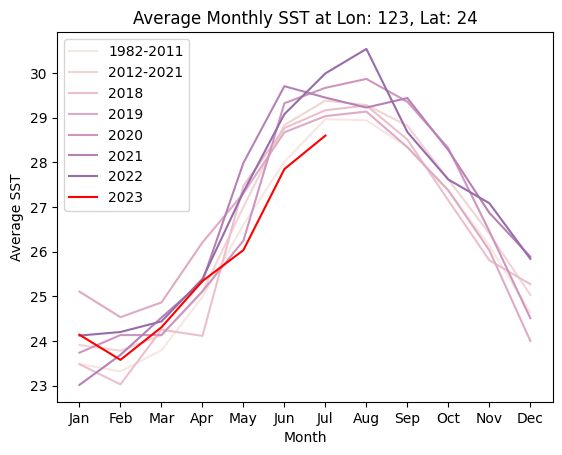

In [18]:
month_climatology(lon0=123, lat0=24, sstvar="sst", period="1982-2011,2012-2021,2018,2019,2020,2021,2022,2023")


Xarray subsetting time:  0.007351398468017578 sec
Exec avg and reset index time:  0.09246540069580078 sec
          date        sst
492 2023-01-01  27.868492
493 2023-02-01  28.099249
494 2023-03-01  28.457235
495 2023-04-01  28.954374
496 2023-05-01  28.716286
497 2023-06-01  27.931671
498 2023-07-01  27.489365
Process date data time:  0.0009284019470214844 sec


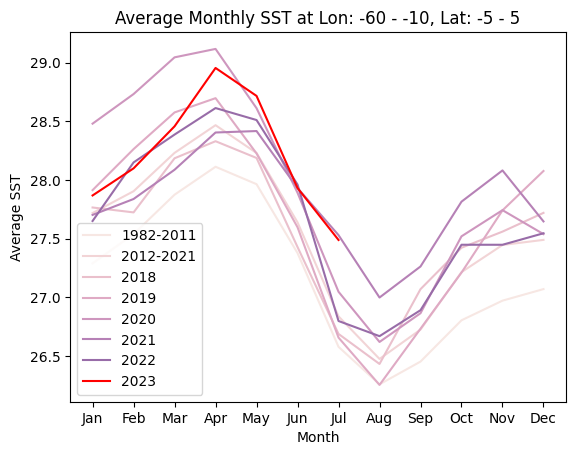

In [19]:
month_climatology(lon0=-60, lat0=-5, lon1=-10, lat1=5, sstvar="sst", period="1982-2011,2012-2021,2018,2019,2020,2021,2022,2023")


Xarray subsetting time:  0.19739580154418945 sec
Exec avg and reset index time:  7.8199827671051025 sec
          date        sst
492 2023-01-01  19.103642
493 2023-02-01  19.259571
494 2023-03-01  19.375515
495 2023-04-01  19.372324
496 2023-05-01  19.256182
497 2023-06-01  19.291218
498 2023-07-01  19.336905
Process date data time:  0.002506732940673828 sec


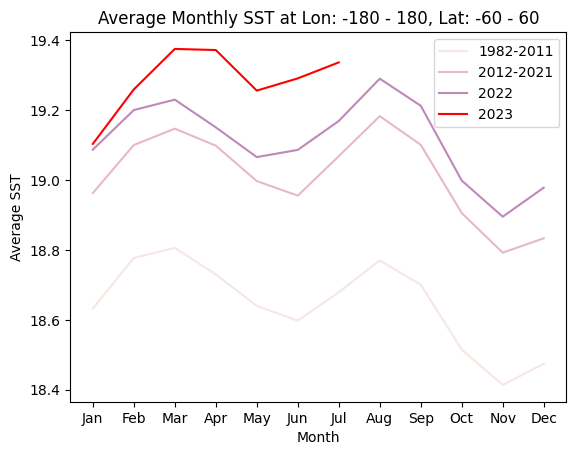

In [20]:
month_climatology(lon0=-180, lat0=-60, lon1=180, lat1=60, sstvar="sst", period="1982-2011,2012-2021,2022,2023")

In [21]:
import matplotlib.pyplot as plt

def region_climatology(bbox: str, start: str, end: str, sstvar: Optional[str] = None, palette: Optional[str] = None):
    bbox_list = bbox.strip('()').split('),(')
    if not sstvar or sstvar.strip() not in ['sst', 'sst_anomaly']:
        sstvar = 'sst'

    if not palette:
        palette = sns.cubehelix_palette(len(bbox_list), gamma=.5)
    else:
        palette = [var.strip() for var in palette.split(',')]
        if len(palette) < len(bbox_list):
            palette = palette + sns.cubehelix_palette(len(bbox_list) - len(palette), gamma=.5)
        elif len(palette) > len(bbox_list):
            palette = palette[0:len(bbox_list)]

    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, bbox_str in enumerate(bbox_list):
        bbox_coords = [float(coord) for coord in bbox_str.split(',')]
        if len(bbox_coords) == 2:
            lon0, lat0, lon1, lat1 = bbox_coords[0], bbox_coords[1], None, None
        elif len(bbox_coords) == 4:
            lon0, lat0, lon1, lat1 = bbox_coords
        else:
            raise HTTPException(
                status_code=400, detail="Invalid bounding box format. Must contain 2 or 4 coordinates.")
        
        #print(lon0, lon1, lat0, lat1, start, end)
        _, df = process_mhw_data(lon0=lon0, lon1=lon1, lat0=lat0, lat1=lat1, start=start, end=end, append=sstvar, mode='area_mean_'+sstvar)
        df = df.sort('date') # Ensure data is in chronological order
        
        # Convert date to year-month format for plotting
        #df = df.with_columns(pl.col('date').dt.strftime('%Y-%m').alias('year_month'))
        
        ax.plot(df['date'], df[sstvar].to_list(), color=palette[i], label=f'BBOX{i+1}: ({bbox_str})')
    
    if sstvar == 'sst':
        ylab = 'SST'
    else:
        ylab = 'SST Anomaly'    

    # Set the date formatter for the x-axis to only display the year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set the major ticks to be every 5 years
    #ax.xaxis.set_major_locator(mdates.YearLocator(5))
    major_ticks = mdates.YearLocator()
    ax.xaxis.set_major_locator(major_ticks)

    # Set the minor ticks to be each month
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Increase the length of the major ticks
    ax.tick_params(which='major', length=10)

    # Only display labels for every 5th major tick
    for i, label in enumerate(ax.xaxis.get_majorticklabels()):
        if int(label.get_text()) % 5 != 0:
            label.set_visible(False)
            
    ax.tick_params(which='major', length=10)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylab)
    ax.set_title(f"{ylab} Climatology from {start} to {end}")
    fig.autofmt_xdate()   
    plt.show()

Xarray subsetting time:  0.011218786239624023 sec
Exec avg and reset index time:  0.1640169620513916 sec
          date  sst_anomaly
492 2023-01-01     0.667215
493 2023-02-01     0.696563
494 2023-03-01     0.429557
495 2023-04-01     0.673955
496 2023-05-01     0.469286
497 2023-06-01     0.335471
498 2023-07-01     0.516114
Process date data time:  0.002393960952758789 sec
Xarray subsetting time:  0.0073206424713134766 sec
Exec avg and reset index time:  0.08299112319946289 sec
          date  sst_anomaly
492 2023-01-01     0.578360
493 2023-02-01     0.560149
494 2023-03-01     0.582369
495 2023-04-01     0.841536
496 2023-05-01     0.751758
497 2023-06-01     0.554085
498 2023-07-01     0.475370
Process date data time:  0.002295255661010742 sec


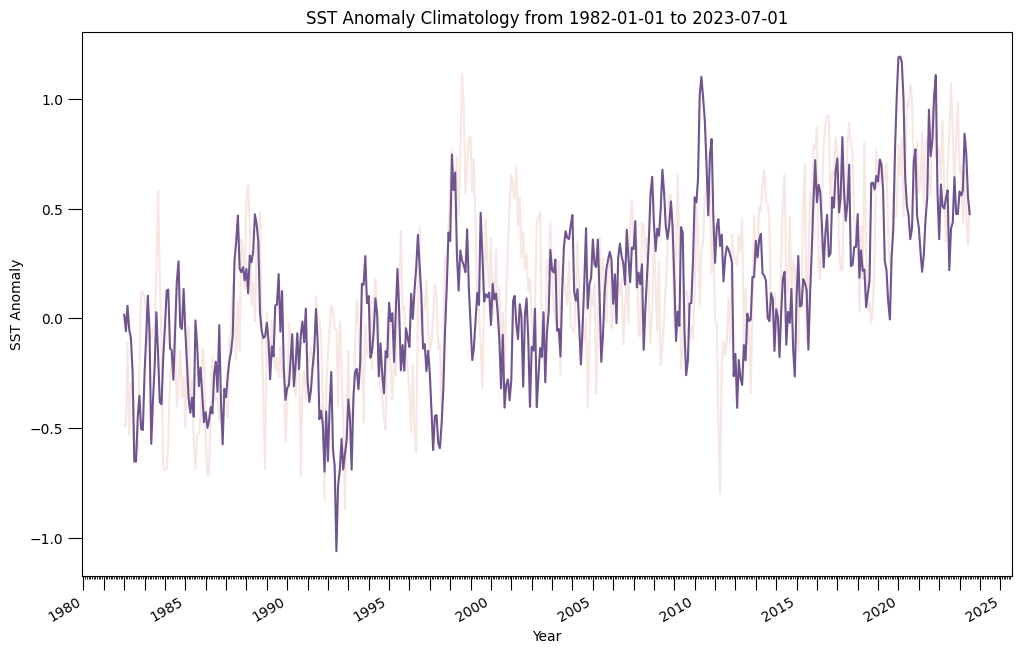

In [23]:
region_climatology("(105,5,135,35),(-60,-5,-10,5)", start='1982-01-01', end='2023-07-01', sstvar='sst_anomaly')

Xarray subsetting time:  0.007780790328979492 sec
Exec avg and reset index time:  0.16186070442199707 sec
          date        sst
492 2023-01-01  24.747293
493 2023-02-01  24.427801
494 2023-03-01  24.671974
495 2023-04-01  26.193125
496 2023-05-01  27.458475
497 2023-06-01  28.279966
498 2023-07-01  28.869507
Process date data time:  0.002181529998779297 sec
Xarray subsetting time:  0.007245063781738281 sec
Exec avg and reset index time:  0.0815742015838623 sec
          date        sst
492 2023-01-01  27.868492
493 2023-02-01  28.099249
494 2023-03-01  28.457235
495 2023-04-01  28.954374
496 2023-05-01  28.716286
497 2023-06-01  27.931671
498 2023-07-01  27.489365
Process date data time:  0.0009522438049316406 sec


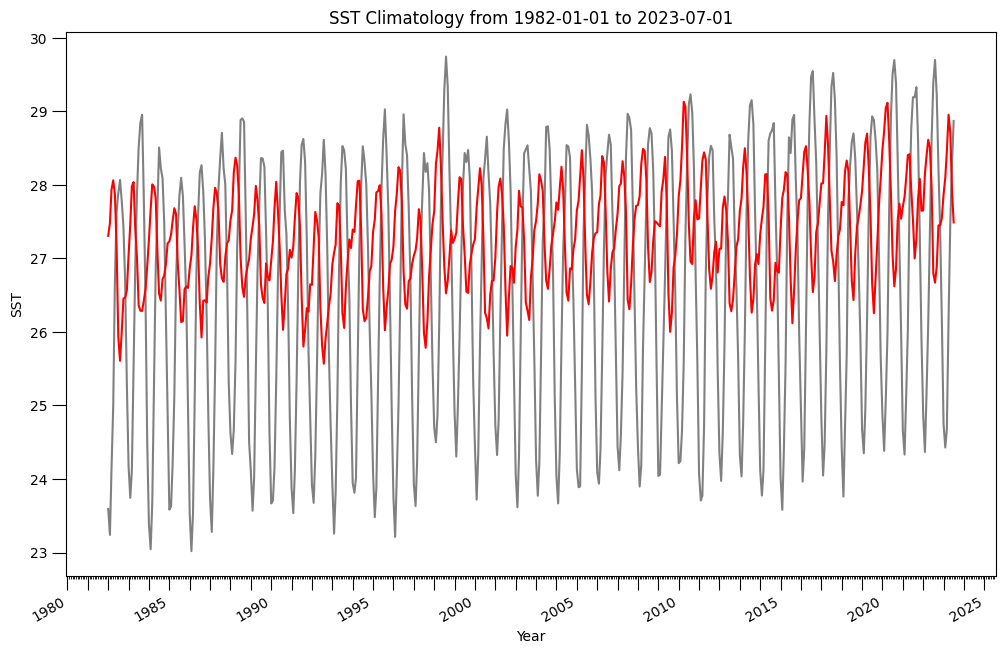

In [24]:
region_climatology("(105,5,135,35),(-60,-5,-10,5)", start='1982-01-01', end='2023-07-01', palette="grey, red")

In [26]:
def climatology(bbox: str, period: str, sstvar: Optional[str] = None, mode: Optional[str] = None, palette: Optional[str] = None):
    if not mode or mode.strip() not in ['month', 'series']:
        mode = 'series'
    
    if mode == 'month':
        bbox_list = bbox.strip('()').split('),(')
        bbox_coords = [float(coord) for coord in bbox_list[0].split(',')]
        if len(bbox_coords) == 2:
            lon0, lat0, lon1, lat1 = bbox_coords[0], bbox_coords[1], None, None
        elif len(bbox_coords) == 4:
            lon0, lat0, lon1, lat1 = bbox_coords
        else:
            raise HTTPException(
                status_code=400, detail="Invalid bounding box format. Must contain 2 or 4 coordinates.")
        
        month_climatology(lon0=lon0, lat0=lat0, lon1=lon1, lat1=lat1, period=period, sstvar=sstvar, palette=palette)

    else:
        if period == "all":
            start = '1982-01-01'
            end = str((datetime.today() - pd.DateOffset(months=1)).replace(day=1).date())
        else:
            start, end = period2date(period.strip().split(',')[0])
            
        region_climatology(bbox=bbox, start=start, end=end, sstvar=sstvar, palette=palette)

    


Xarray subsetting time:  0.004848480224609375 sec
Exec avg and reset index time:  0.1630113124847412 sec
          date        sst
492 2023-01-01  24.747293
493 2023-02-01  24.427801
494 2023-03-01  24.671974
495 2023-04-01  26.193125
496 2023-05-01  27.458475
497 2023-06-01  28.279966
498 2023-07-01  28.869507
Process date data time:  0.0019190311431884766 sec
Xarray subsetting time:  0.011925220489501953 sec
Exec avg and reset index time:  0.07806015014648438 sec
          date        sst
492 2023-01-01  27.868492
493 2023-02-01  28.099249
494 2023-03-01  28.457235
495 2023-04-01  28.954374
496 2023-05-01  28.716286
497 2023-06-01  27.931671
498 2023-07-01  27.489365
Process date data time:  0.0008356571197509766 sec


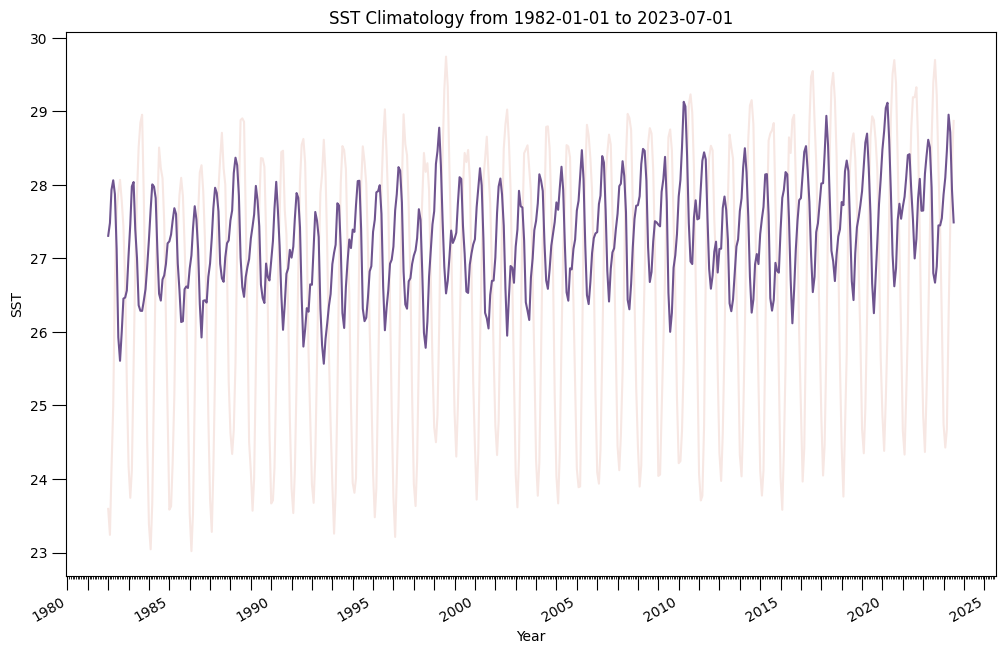

In [27]:
climatology("(105,5,135,35),(-60,-5,-10,5)", period='19820101-202307', mode="series")

Xarray subsetting time:  0.007803678512573242 sec
Exec avg and reset index time:  0.15469956398010254 sec
          date        sst
492 2023-01-01  24.747293
493 2023-02-01  24.427801
494 2023-03-01  24.671974
495 2023-04-01  26.193125
496 2023-05-01  27.458475
497 2023-06-01  28.279966
498 2023-07-01  28.869507
Process date data time:  0.0015399456024169922 sec


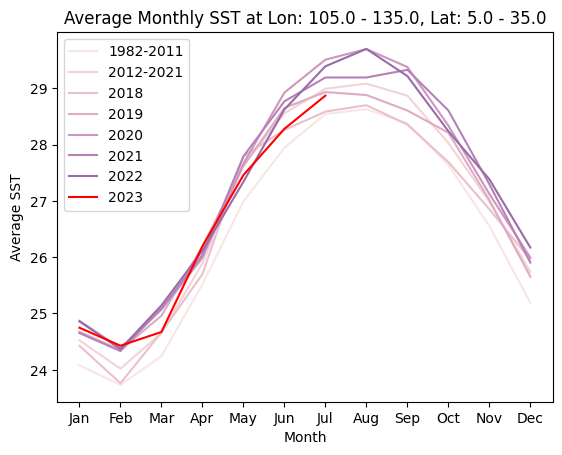

In [28]:
climatology("(105,5,135,35),(-60,-5,-10,5)", period="1982-2011,2012-2021,2018,2019,2020,2021,2022,2023", mode="month")